In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import os
import gc
import seaborn as sns
import tensorflow as tf
import scipy.misc

from os import listdir
from os.path import isfile, join

from skimage.transform import resize

import warnings
print('TF',tf.__version__)
print('NP',np.__version__)

#Train data local  path
train_data_path='/mnt/disks/disk_b/Data/train/'  #4196594

TF 1.13.1
NP 1.16.3


In [0]:
##READING LABELS

def download_labels():
  
  if  os.path.isfile('train.csv')==False:

    !wget 'https://s3.amazonaws.com/google-landmark/metadata/train.csv'

  train_data = pd.read_csv('train.csv')
  print('Number of examples: ',len(train_data))
  
  return train_data
  
train_data=download_labels()



In [0]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import threading
import urllib
import cv2
import time

import keras
from keras.applications import ResNet50,InceptionResNetV2
from keras.applications import DenseNet121
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from sklearn.model_selection import train_test_split

from collections import Counter

import os

Using TensorFlow backend.


In [0]:
NUM_THRESHOLD = 250
train=train_data

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_urls = train['url'].tolist()
#all_ids=train['id'].tolist()
all_ids=train['id'].tolist()

all_landmarks = train['landmark_id'].tolist()

valid_ids_dict = {x[0]:landmark_to_idx[x[1]] for x in zip(all_ids, all_landmarks) if x[1] in landmarks_dict}
valid_ids_list = [x[0] for x in zip(all_ids, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_ids_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))


Total number of valid classes: 1067
Total number of valid examples: 478577


In [0]:
train1_ids, test_ids = train_test_split(valid_ids_list, test_size=10*NUM_CLASSES/NUM_EXAMPLES,random_state=1234)
train_ids, validation_ids = train_test_split(train1_ids, test_size=10*NUM_CLASSES/NUM_EXAMPLES,random_state=1234)

In [0]:
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        img_original = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(img_original,(128, 128), interpolation=cv2.INTER_AREA)
        return foo,img_original
    except:
        return np.array([]),np.array([])

In [0]:
print(train_data_path)
def download_local(filename,train_data_path=train_data_path):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    #path="/content/drive/My Drive/CS231n/Project/Data/Train/0/0/0/"
    #path='/home/kate_for_it/Project/train/'
    path=train_data_path
    try:
        
        img_original=cv2.imread(path+filename+'.jpg',cv2.IMREAD_COLOR)
        #print(path+filename+'.jpg')
        img_resized = cv2.resize(img_original,(128, 128), interpolation=cv2.INTER_AREA)

        return img_resized,img_original
    except:
        return np.array([]),np.array([])

/mnt/disks/disk_b/Data/train/


In [0]:
valid_x=[]
valid_y=[]

for item in validation_ids:

    valid_xi,_=download_local(item)
   
    valid_yi=valid_ids_dict[item]
    if valid_xi.shape[0]>0:
        valid_x.append(valid_xi)
        valid_y.append(valid_yi)
print(len(valid_x))

y = np.zeros((len(valid_x), NUM_CLASSES))
        
for i in range(len(valid_y)):
    y[i,valid_y[i]] = 1.
valid_y=y
valid_x=np.array(valid_x)

10241


In [0]:
def randomCrop(img, width, height):
   
    
    x = random.randint(0, max(img.shape[1] - width,0))
    y = random.randint(0, max(img.shape[0] - height,0))
    
    img_crop = img[y:y+height, x:x+width]
  
    return img_crop



class DataGen(Sequence):
    def __init__(self, data, batch_size=24, verbose=1):
        self.batch_size=batch_size
        self.data_urls = data

    def normalize(self,data):
        return data
    
    def __getitem__(self, index):
      
        number_of_crops=1
        
        
        batch_urls = random.sample(self.data_urls, int(self.batch_size/number_of_crops))
   
        
        output = []
        y_classes = []
        
        for url in batch_urls:
            im,original = download_local(url)
            if im.size != 0:
               
                output.append(im)
                y_classes.append(valid_ids_dict[url.split("/")[-1]])
                if original.shape[0]<=128 or original.shape[1]<=128: 
                  original=cv2.resize(original,(256, 256), interpolation=cv2.INTER_AREA)
                for k in range(number_of_crops-1):
                 
                  im=randomCrop(original,128,128)
                  output.append(im)
                  y_classes.append(valid_ids_dict[url.split("/")[-1]])
                  
        
        x = np.array(output)
        #print(x.shape)
        y = np.zeros((len(output), NUM_CLASSES))
        
        for i in range(len(y_classes)):
            y[i,y_classes[i]] = 1.
        
        #print(x.shape)
        return x,y
            
    def on_epoch_end(self):
        return

    def __len__(self):
        #return len(valid_urls_list) // self.batch_size
        #number_of_crops=16
        #return int(470000/(self.batch_size/number_of_crops)) 
        #minis
        #NUM_CLASSES*250//(self.batch_size/number_of_crops)
        return 400
      
def accuracy_class(y_true, y_pred):
    true = K.argmax(y_true, axis=1)
    pred = K.argmax(y_pred, axis=1)
    matches = K.equal(true, pred)
    return K.mean(matches)
  
#adapted from https://github.com/jandaldrop/landmark-recognition-challenge/blob/master/landmarks-xception.ipynb  
def batch_GAP(y_t, y_p):
  
    import tensorflow as tf
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP  
  
def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * NUM_CLASSES

#GeM

gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    import tensorflow as tf
    
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool


def auroc(y_true, y_pred):
    from sklearn.metrics import roc_auc_score
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# VGG 16 Places 365 scripts in custom dataset
os.chdir("/content/drive/My Drive/CS231n/Project/VGG_places/")
from vgg16_places_365 import VGG16_Places365
os.chdir("/content/drive/My Drive/CS231n/Project/VGG_places/working/")
# Places365 Model
vgg = VGG16_Places365(weights='places',include_top=False)

In [0]:
for layer in vgg.layers[:19]:
    layer.trainable = False


In [0]:

#res_net
res_net=ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
print(len(res_net.layers))
for layer in res_net.layers[:120]:
    layer.trainable = False

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


175


In [0]:

#GEM

X_feat = Input(res_net.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)  # add input output shape
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dense(512)(X)
X = Dropout(0.5)(X)

X = Dense(NUM_CLASSES, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
#top_model.summary()

#all together

X_image = Input(res_net.input_shape[1:])

X_f = res_net(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
model_3 (Model)              (None, 1067)              1596460   
Total params: 25,184,172
Trainable params: 18,811,948
Non-trainable params: 6,372,224
_________________________________________________________________


In [0]:
#https://github.com/HiKapok/tf.extra_losses
import math
def constant_xavier_initializer(shape, dtype=tf.float32, uniform=True):
    """Initializer function."""
    if not dtype.is_floating:
      raise TypeError('Cannot create initializer for non-floating point type.')
    # Estimating fan_in and fan_out is not possible to do perfectly, but we try.
    # This is the right thing for matrix multiply and convolutions.
    if shape:
      fan_in = float(shape[-2]) if len(shape) > 1 else float(shape[-1])
      fan_out = float(shape[-1])
    else:
      fan_in = 1.0
      fan_out = 1.0
    for dim in shape[:-2]:
      fan_in *= float(dim)
      fan_out *= float(dim)

    # Average number of inputs and output connections.
    n = (fan_in + fan_out) / 2.0
    if uniform:
      # To get stddev = math.sqrt(factor / n) need to adjust for uniform.
      limit = math.sqrt(3.0 * 1.0 / n)
      return tf.random_uniform(shape, -limit, limit, dtype, seed=None)
    else:
      # To get stddev = math.sqrt(factor / n) need to adjust for truncated.
      trunc_stddev = math.sqrt(1.3 * 1.0 / n)
      return tf.truncated_normal(shape, 0.0, trunc_stddev, dtype, seed=None)


def ArcFaceLoss(features, labels, embedding_dim, num_classes, scale=64., margin=0.5, easy_margin=True, scope=None):
    '''
    margin should in range [0, pi/2)
    '''
    with tf.variable_scope(scope, "ArcFaceLoss", [features, labels]):
        cos_m = math.cos(margin)
        sin_m = math.sin(margin)
        mm = math.sin(math.pi - margin) * margin
        threshold = math.cos(math.pi - margin)

        var_weights = tf.Variable(constant_xavier_initializer([num_classes, embedding_dim]), name='weights')
        normed_weights = tf.nn.l2_normalize(var_weights, 1, 1e-10, name='weights_norm')
        normed_features = tf.nn.l2_normalize(features, 1, 1e-10, name='features_norm')
        
        print('good')
        cosine = tf.matmul(normed_features, normed_weights, transpose_a=False, transpose_b=True)
        one_hot_mask = tf.one_hot(labels, num_classes, on_value=1., off_value=0., axis=-1, dtype=tf.float32)

        cosine_theta_2 = tf.pow(cosine, 2., name='cosine_theta_2')
        sine_theta = tf.pow(1. - cosine_theta_2, .5, name='sine_theta')

        cosine_theta_m = scale * (cos_m * cosine - sin_m * sine_theta) * one_hot_mask

        if easy_margin:
            clip_mask = tf.to_float(cosine >= 0.) * scale * cosine * one_hot_mask
        else:
            clip_mask = tf.to_float(cosine >= threshold) * scale * mm * one_hot_mask

        cosine = scale * cosine * (1. - one_hot_mask) + tf.where(clip_mask > 0., cosine_theta_m, clip_mask)

        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                            logits=cosine), name='arc_loss')
def test_arc_loss():
    loss = ArcFaceLoss(tf.constant(features), tf.constant(labels), 6, NUM_CLASSES)

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print('arc_loss:', sess.run(loss))
    
#features = [[0.1, 0.2, -0.3, -0.4], [-1.1, -1.2, 1.3, 1.4], [2.1, 2.2, -2.3, -2.4]]
features=[[1.1205244e-06, 1.1920171e-05, 8.9665857e-04,1.6042441e-05,2.7358397e-05,4.2896249e-06],
 [3.2736876e-03,3.0517898e-05,1.9684444e-04,5.7466910e-05,4.1320477e-06,7.5294716e-05]]
labels = [3, 2]  
test_arc_loss()

def get_custom_loss(emb_dim=NUM_CLASSES, num_classes=NUM_CLASSES):
    def custom_loss(y_t, y_p):
        #y_t, y_p
        f=y_p
        l=tf.transpose(tf.cast(y_t, tf.int32))
        loss=ArcFaceLoss(f, l, emb_dim, num_classes)
        return loss
    return custom_loss

good
Instructions for updating:
Use tf.cast instead.
arc_loss: 67.18291


In [0]:
#customloss #2
#https://github.com/jandaldrop/landmark-recognition-challenge/blob/master/landmarks-xception.ipynb
def get_custom_loss2(rank_weight=1., epsilon=1.e-9):
    def custom_loss(y_t, y_p):
        losses = tf.reduce_sum(-y_t*tf.log(y_p+epsilon) - (1.-y_t)*tf.log(1.-y_p+epsilon), 
                               axis=-1)
        
        pred_idx = tf.argmax(y_p, axis=-1)
        
        mask = tf.one_hot(pred_idx, 
                          depth=y_p.shape[1], 
                          dtype=tf.bool, 
                          on_value=True, 
                          off_value=False)
        pred_cat = tf.boolean_mask(y_p, mask)
        y_t_cat = tf.boolean_mask(y_t, mask)
        
        n_pred = tf.shape(pred_cat)[0]
        _, ranks = tf.nn.top_k(pred_cat, k=n_pred)
        
        ranks = tf.cast(n_pred-ranks, tf.float32)/tf.cast(n_pred, tf.float32)*rank_weight
        rank_losses = ranks*(-y_t_cat*tf.log(pred_cat+epsilon)
                             -(1.-y_t_cat)*tf.log(1.-pred_cat+epsilon))        
        
        return rank_losses + losses
    return custom_loss

In [0]:

from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import History, CSVLogger,ReduceLROnPlateau,ModelCheckpoint
history = keras.callbacks.History()

#loss = get_custom_loss2()
model_name='resnet_dropoutV2_2dense_250_0604'

LOG_DIR='/home/kate_for_it/Project/LOG/'
Check_DIR='/home/kate_for_it/Project/Checkpoint/'


csv_logger = CSVLogger(LOG_DIR+'training_'+model_name+'.log')

opt = Adam(0.00001)
#opt = Adam(0.00001)

checkpoint_name=model_name+'.h5'
checkpoint_filepath=Check_DIR+checkpoint_name


checkpoint=keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

model.compile(#loss=loss
              loss="binary_crossentropy"
              , optimizer=opt, metrics=[accuracy_class,batch_GAP,binary_crossentropy_n_cat])

#check dir


In [0]:
if os. path. isfile(checkpoint_filepath):
  model.load_weights(checkpoint_filepath)
  print("Best weights loaded")


In [0]:
model.fit_generator(generator=DataGen(train_ids, batch_size=128),
                    shuffle=True,
                    validation_data=[valid_x, valid_y],
                    epochs=40,
                    use_multiprocessing=True,
                    workers=8,
                    verbose=1,
                    callbacks=[history,csv_logger,checkpoint#,reduce_lr
                              ])

Epoch 1/40
400/400 [==============================] - 260s 650ms/step - loss: 0.0084 - accuracy_class: 0.0243 - batch_GAP: 0.0018 - binary_crossentropy_n_cat: 8.9814 - val_loss: 0.0074 - val_accuracy_class: 0.0426 - val_batch_GAP: 0.0035 - val_binary_crossentropy_n_cat: 7.9417
Epoch 2/40
400/400 [==============================] - 248s 619ms/step - loss: 0.0073 - accuracy_class: 0.0547 - batch_GAP: 0.0052 - binary_crossentropy_n_cat: 7.7507 - val_loss: 0.0070 - val_accuracy_class: 0.0670 - val_batch_GAP: 0.0074 - val_binary_crossentropy_n_cat: 7.4971
Epoch 3/40
400/400 [==============================] - 247s 618ms/step - loss: 0.0069 - accuracy_class: 0.0810 - batch_GAP: 0.0101 - binary_crossentropy_n_cat: 7.3174 - val_loss: 0.0068 - val_accuracy_class: 0.0865 - val_batch_GAP: 0.0111 - val_binary_crossentropy_n_cat: 7.2229
Epoch 4/40
400/400 [==============================] - 248s 619ms/step - loss: 0.0066 - accuracy_class: 0.1080 - batch_GAP: 0.0158 - binary_crossentropy_n_cat: 6.9963 

In [0]:
#batch_GAP: 0.0871
x_=valid_x
y_=valid_y

def val_gap(x_,y_):

  result=model.predict(x_, batch_size=128, verbose=0, steps=None)

  true_=y_.astype('int64')
  pred_=result

  _,acc=tf.metrics.average_precision_at_k(true_,pred_,1)
  custom_gap=batch_GAP(true_,pred_)

  sess = tf.Session()
  sess.run(tf.local_variables_initializer())

  print('Validation GAP: ',sess.run(acc))
  print('Custom GAP: ', sess.run(custom_gap))

val_gap(x_,y_)

#with crops 0.7445346658338539

Validation GAP:  0.00039058685675227026
Custom GAP:  0.048534393


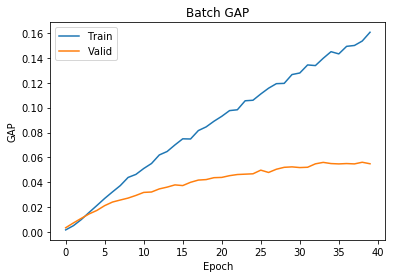

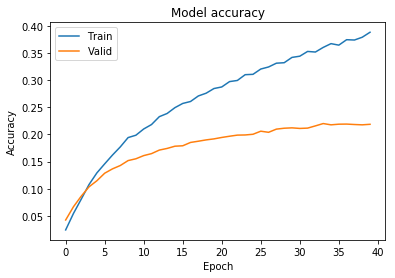

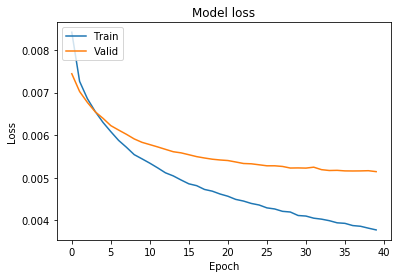

In [0]:
import matplotlib.pyplot as plt

#history
#loss: 0.0086 - accuracy_class
# Plot training & validation accuracy values
plt.plot(history.history['batch_GAP'])
plt.plot(history.history['val_batch_GAP'])
plt.title('Batch GAP')
plt.ylabel('GAP')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy_class'])
plt.plot(history.history['val_accuracy_class'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()